In [1]:
#Import Packages
#Requires Python 3.10 or earlier
import py_wake
import numpy as np
import matplotlib.pyplot as plt
import math

from py_wake import NOJ

#Define Situation
shore_point_longLat = [(-2.190087, 56.976389)] #Shore point longatude, Latitude

num_turb_per_row = [6,6,4,3,1] # Number of turbines on each row


/home/andrew/repos/Uni Work/WindFarm2/.venv310/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<xarray.DataArray (sector: 12)> Size: 96B
array([0.06, 0.04, 0.04, 0.04, 0.05, 0.08, 0.12, 0.17, 0.18, 0.06, 0.06,
       0.1 ])
Coordinates:
  * sector   (sector) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
Attributes:
    description:  Probability of wind flow case (i.e. wind direction and wind...

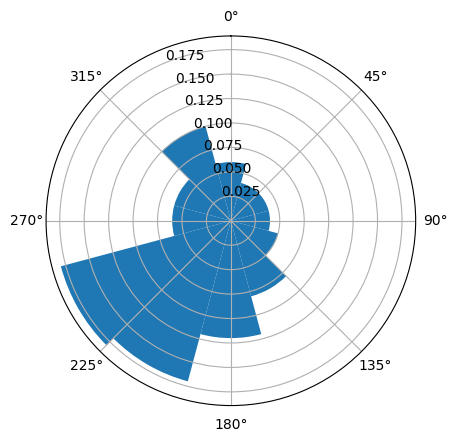

In [2]:
#Define Site
from py_wake.site import UniformWeibullSite
# Dummy offshore site object
wd = np.arange(0, 360, 30)
A = np.full_like(wd, 9.5, dtype=float) # Weibull scale parameter
k = np.full_like(wd, 2.0, dtype=float) # Weibull shape parameter

p_wd = np.array([0.06, 0.04, 0.04, 0.04, 0.05, 0.08, 0.12, 0.17, 0.18, 0.06, 0.06, 0.1], dtype=float) # sector frequencies (defines wind direction)
p_wd /= p_wd.sum()

site = UniformWeibullSite(p_wd=p_wd, a=A, k=k, ti=0.08) # Create uniform weibull site
site.plot_wd_distribution(n_wd=12) # Plot wind rose

****Wind turbine specifications****

Power and Thrust coefficient (Ct) curves:


"\nwt = WindTurbine(name='MyWT',\n                    diameter=124,\n                    hub_height=320,\n                    powerCtFunction=PowerCtTabular(u,power,'kW',thrust_coeff))\n\nor \n\nwt = GenericWindTurbine('G10MW', 180, 120, power_norm=10000, turbulence_intensity=.1)\n\nSource: https://www.pythonpool.com/pywake-library/\n"

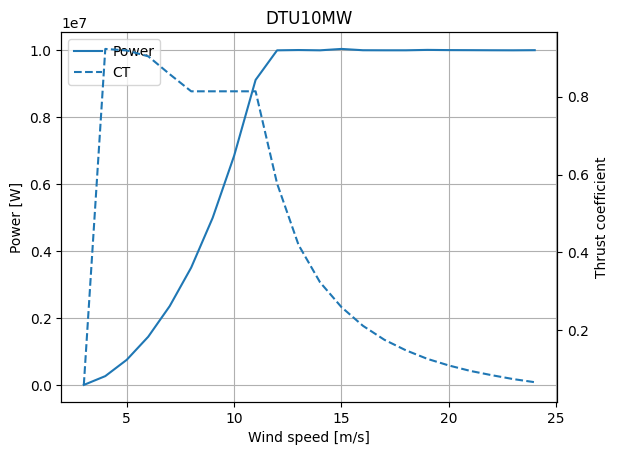

In [3]:
#Define Turbine
from py_wake.wind_turbines import WindTurbines
from py_wake.examples.data.dtu10mw import DTU10MW
from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
import numpy as np

diameter = 200 #Turbine blade diameter in m
hub_height = 127 #Hub height in m

wt = DTU10MW() #Example 10mw turbine https://backend.orbit.dtu.dk/ws/portalfiles/portal/55645274/The_DTU_10MW_Reference_Turbine_Christian_Bak.pdf

#Plot Data
print('****Wind turbine specifications****\n')
print("Power and Thrust coefficient (Ct) curves:")
ws = np.arange(3,25)
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')
wt.plot_power_ct(ws=ws)

'''
wt = WindTurbine(name='MyWT',
                    diameter=124,
                    hub_height=320,
                    powerCtFunction=PowerCtTabular(u,power,'kW',thrust_coeff))

or 

wt = GenericWindTurbine('G10MW', 180, 120, power_norm=10000, turbulence_intensity=.1)

Source: https://www.pythonpool.com/pywake-library/
'''

In [4]:
#Define Turbine layout

# number of turbines in each direction:
#n_x = 5
#n_y = 4
#total_turbine = 20

rotor_diameter = diameter
dist_x = 4 * rotor_diameter
dist_y = 5 * rotor_diameter

wt_x = np.empty(0)
for row in range(len(num_turb_per_row)):
    for turbine in range(num_turb_per_row[row]):
        wt_x = np.append(wt_x,turbine*dist_x)


wt_y= np.empty(0)
for row in range(len(num_turb_per_row)):
    for turbine in range(num_turb_per_row[row]):
        wt_y = np.append(wt_y,row*dist_y)


# This defines the turbine positions
#print((x_array, y_array))
#print(np.meshgrid(np.array(range(n_x)) * dist_x, np.array(range(n_y)) * dist_y))

#wt_x, wt_y = np.meshgrid(x_array, np.array(range(n_y)) * dist_y)
#wt_x, wt_y = np.meshgrid(np.array(range(n_x)) * dist_x, np.array(range(n_y)) * dist_y)
wt_x = wt_x.flatten()
wt_y = wt_y.flatten()

print(wt_x, wt_y)

#x_max, x_min = wt_x.max(), wt_x.min()
#y_max, y_min = wt_y.max(), wt_y.min()

n_wt = sum(num_turb_per_row)


[   0.  800. 1600. 2400. 3200. 4000.    0.  800. 1600. 2400. 3200. 4000.
    0.  800. 1600. 2400.    0.  800. 1600.    0.] [   0.    0.    0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000.
 2000. 2000. 2000. 2000. 3000. 3000. 3000. 4000.]


In [5]:
#Define Engineering windfarm model
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
windFarmModel = Bastankhah_PorteAgel_2014(site, wt, k=0.0324555)

Total AEP: 738.789890 GWh


Text(0.5, 1.0, 'AEP vs wind direction')

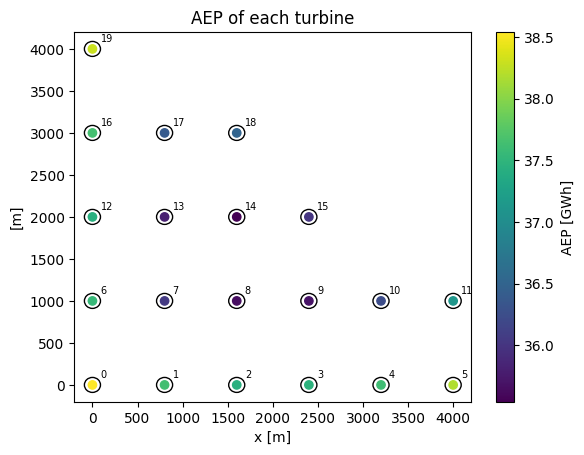

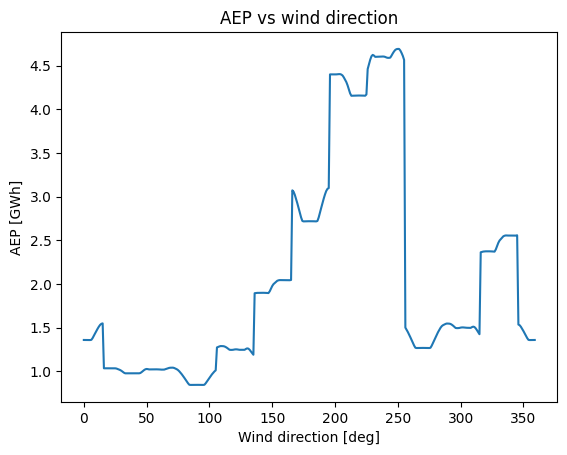

In [6]:
#Calculate AEP (Annual Energy Production)
from py_wake import NOJ

#import the wake deficit model
noj = NOJ(site,wt)
simulationResult = noj(wt_x,wt_y)

#Display Results
print ("Total AEP: %f GWh"%simulationResult.aep().sum())

plt.figure()
aep = simulationResult.aep() 
wt.plot(wt_x,wt_y)
c =plt.scatter(wt_x, wt_y, c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.title('AEP of each turbine')
plt.xlabel('x [m]')
plt.ylabel('[m]')

plt.figure()
aep.sum(['wt','ws']).plot()
plt.xlabel("Wind direction [deg]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind direction')

Text(0.5, 1.0, 'Wake map for 10 m/s and 225 deg')

<Figure size 640x480 with 0 Axes>

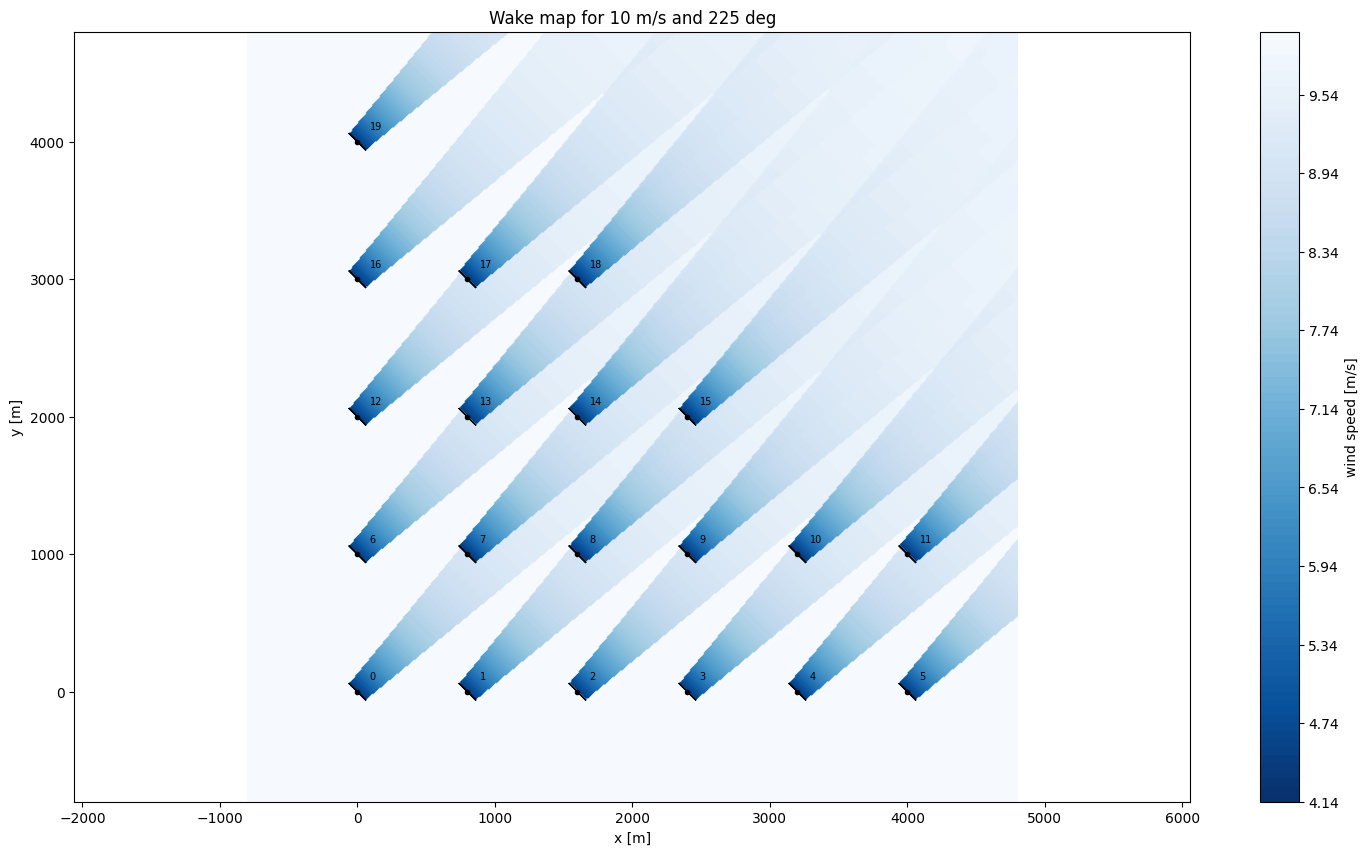

: 

In [ ]:
#Plot Flow Map
wind_speed = 10
wind_direction = 225

plt.figure()
flow_map = simulationResult.flow_map(ws=wind_speed, wd=wind_direction)
plt.figure(figsize=(18,10))
flow_map.plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for' + f' {wind_speed} m/s and {wind_direction} deg')

# --- TopFarm imports ---
from topfarm._topfarm import TopFarmProblem
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.easy_drivers import EasyScipyOptimizeDriver as fd

#Converstions between degrees on earth and m
def m2d_lat(m):
    return m / 111000

def m2d_lon(m, lat_deg):
    return m / (111000 * math.cos(math.radians(lat_deg)))

def d2m_lat(d):
    return d * 111000

def d2m_lon(d, lat_deg):
    return d * (111000 * math.cos(math.radians(lat_deg)))
'''
boundry_longLat = [
    (1.981910,56.921167),
    (1.974451,56.919002),
    (1.966039,56.911034),
    (1.964135,56.899420),
    (1.968893,56.888238),
    (1.985715,56.877331),
    (1.992857,56.878285),
    (1.992222,56.886262),
    (2.001586,56.893891),
    (1.989365,56.914342)
]
'''

boundry_longLat = [
    (2.044477,56.822299),
    (2.018068,56.873226),
    (1.997297,56.871540),
    (1.987327,56.863495),
    (1.984623,56.850720),
    (1.962953,56.836754),
    (1.953877,56.828867),
    (1.980750,56.804633)
]


boundary = [[0] for _ in range(len(boundry_longLat))] # Pre-allocate space for boundry in m

for b in range(len(boundry_longLat)):
    relative_long = boundry_longLat[0][0] - boundry_longLat[b][0]
    boundary[b][0] = d2m_lon(relative_long, boundry_longLat[b][1])

    relative_lat = boundry_longLat[b][1] - boundry_longLat[0][1]
    boundary[b].append(d2m_lat(relative_lat))
    #print(boundary[b][0],",",boundary[b][1])

#Split boundary into seperate x and y for plotting
bound_x = [p[0] for p in boundary] + [boundary[0][0]]
bound_y = [p[1] for p in boundary] + [boundary[0][1]]

#Plot Boundary
plt.figure()
plt.plot(bound_x,bound_y,"m--")

x_max, x_min = wt_x.max(), wt_x.min()
y_max, y_min = wt_y.max(), wt_y.min()

x0, y0 = np.meshgrid(np.array(range(n_x)) * dist_x, np.array(range(n_y)) * dist_y)
x0 = x0.flatten() 
y0 = y0.flatten()
def get_topfarmProblem_xy(wfm, x, y, grad_method, maxiter, n_cpu):
    
    farm_boundary = np.array(boundary)
    boundary_constr = XYBoundaryConstraint( 
        farm_boundary,
        boundary_type='polygon' 
    )

    return TopFarmProblem(
        design_vars={'x': x, 'y': y},
        cost_comp=PyWakeAEPCostModelComponent(
            windFarmModel=wfm,
            n_wt=len(x),
            grad_method=None,
            wd=wfm.site.default_wd,
            ws=wfm.site.default_ws
        ),
        driver=fd(maxiter=maxiter),
        constraints=[
            boundary_constr,
            SpacingConstraint(min_spacing=2 * wfm.windTurbines.diameter())
        ]
    )


def optimize_and_plot(wfm, x0, y0, maxiter):
    method = fd
    n_cpu = 16

    tf = get_topfarmProblem_xy(wfm, x0, y0, method, maxiter, n_cpu)
    cost, state, recorder = tf.optimize(disp=True)

    t, aep = [recorder[v] for v in ['timestamp', 'AEP']]
    plt.figure()
    plt.plot(t - t[0], aep, label=f'{method.__name__}, {n_cpu} CPU')
    plt.xlabel("Time [s]")
    plt.ylabel("AEP [GWh]")
    plt.title("TopFarm Optimization Progress")
    plt.legend()
    plt.show()
    return tf, cost, state, recorder


# --- Run optimization ---
tf, cost, state, recorder = optimize_and_plot(windFarmModel, x0, y0, maxiter=500)
#cost, state, recorder = tf.optimize(disp=True)



#Define Engineering windfarm model for new layout
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
windFarmModelNew = Bastankhah_PorteAgel_2014(site, wt, k=0.0324555)

#import the wake deficit model
noj = NOJ(site,wt)
newSimulationResult = noj(x=state['x'],y=state['y'])

#Get coordinates of new locations and format into list
wt_x_locations=state['x']
wt_y_locations=state['y']
wt_xy_locations = [[0] for _ in range(len(wt_x_locations))] # Pre-allocate space for turbine locations in m

#Get new turbine locations in M
for l in range(len(wt_x_locations)):
    wt_xy_locations[l][0] = float(wt_x_locations[l])
    wt_xy_locations[l].append(float(wt_y_locations[l]))

print("Turbine Locations in M")
print(wt_xy_locations)

#Convert locations to lat and long
wt_lat_long_new = [[0] for _ in range(len(wt_x_locations))]
for t in range(len(wt_lat_long_new)):
    wt_lat_long_new[t][0] = m2d_lat(wt_xy_locations[t][1]) + boundry_longLat[0][1]
    wt_lat_long_new[t].append(m2d_lon(wt_xy_locations[t][0],wt_lat_long_new[t][0]) + boundry_longLat[0][0] * (-1))

print("Turbine Locations in degrees")
print(wt_lat_long_new)

#Display Results for new simulation
print("Total AEP: %f GWh"%newSimulationResult.aep().sum())

# Plot results
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.scatter(state['x'], state['y'], c='red', label='Optimised')
plt.scatter(wt_x, wt_y, c='blue', alpha=0.4, label='Initial')
plt.plot(bound_x, bound_y, 'm--')
plt.legend()
plt.title("Initial vs Optimised Layout")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("equal")

#Plot AEP of Turbines
plt.subplot(2,2,2)
aep = newSimulationResult.aep() 
wt.plot(x=state['x'],y=state['y'])
plt.plot(bound_x, bound_y, 'm--')
c =plt.scatter(x=state['x'],y=state['y'], c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.xlabel('x [m]')
plt.ylabel('[m]')

#Plot AEP vs Wind direction
plt.subplot(2,2,3)
aep.sum(['wt','ws']).plot()
plt.xlabel("Wind direction [deg]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind direction')

#Plot Flow Map for new layout
plt.subplot(2,2,4)
flow_map_new = newSimulationResult.flow_map(ws=wind_speed, wd=wind_direction)
flow_map_new.plot_wake_map()
plt.plot(bound_x, bound_y, 'm--')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for new layout with' + f' {wind_speed} m/s and {wind_direction} deg')
plotName = "Turbine Plot " + str(num_turb_per_row)
plt.savefig("Plots/"+plotName)


In [ ]:
#Place and Optimise cables
#Source https://topfarm.pages.windenergy.dtu.dk/TopFarm2/notebooks/cables.html
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm._topfarm import TopFarmProblem, TopFarmGroup
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.plotting import XYPlotComp, NoPlot
from topfarm.utils import plot_list_recorder
from topfarm.cost_models.electrical.optiwindnet_wrapper import WFNComponent

from py_wake.examples.data.iea37 import IEA37_WindTurbines
from py_wake import BastankhahGaussian
from py_wake.examples.data.hornsrev1 import Hornsrev1Site


from costmodels.finance import Depreciation, Technology, Product
from costmodels.project import Project
from costmodels.models import DTUOffshoreCostModel
from topfarm.examples.bathymetry_ficticio import (
    gaussian_surface,
    get_bathymetry_func_rect,
    plot_bathymetry_rect,
)

#Converstions between degrees on earth and m
def m2d_lat(m):
    return m / 111000

def m2d_lon(m, lat_deg):
    return m / (111000 * math.cos(math.radians(lat_deg)))

def d2m_lat(d):
    return d * 111000

def d2m_lon(d, lat_deg):
    return d * (111000 * math.cos(math.radians(lat_deg)))


# Inputs
plot = True
maxiter = 50
sigma = 3000.0
# Here you set up cables [<number of turbines can be connected>, <price in € per meter>]
cables = np.array([(2, 2000), (5, 2200)])
LIFETIME = 25  # years
el_price = 50  # fixed ppa price Euro per MWh
driver = EasyScipyOptimizeDriver(maxiter=maxiter)

#Geometry
boundry_longLat = [
    (2.044477,56.822299),
    (2.018068,56.873226),
    (1.997297,56.871540),
    (1.987327,56.863495),
    (1.984623,56.850720),
    (1.962953,56.836754),
    (1.953877,56.828867),
    (1.980750,56.804633)
]

boundary = [[0] for _ in range(len(boundry_longLat))] # Pre-allocate space for boundry in m

for b in range(len(boundry_longLat)):
    relative_long = boundry_longLat[0][0] - boundry_longLat[b][0]
    boundary[b][0] = d2m_lon(relative_long, boundry_longLat[b][1])

    relative_lat = boundry_longLat[b][1] - boundry_longLat[0][1]
    boundary[b].append(d2m_lat(relative_lat))

#Split boundary into seperate x and y for plotting
bound_x = [p[0] for p in boundary] + [boundary[0][0]]
bound_y = [p[1] for p in boundary] + [boundary[0][1]]

#Plot Boundary
plt.figure()
plt.plot(bound_x,bound_y,"m--")

x_max, x_min = wt_x.max(), wt_x.min()
y_max, y_min = wt_y.max(), wt_y.min()

#Define Turbine Positions
n_wt = len(wt_x)
turbines_pos=np.asarray([wt_x,wt_y]).T

#Define Substation position

shore_point_longLat = [(-2.190087, 56.976389)] #Shore point longatude, Latitude

shore_point_relative_long = boundry_longLat[0][0] - shore_point_longLat[0][0]

shore_point_relative_lat = boundry_longLat[0][1] - shore_point_longLat[0][1]

substations_pos = np.asarray([d2m_lon(shore_point_relative_long, boundry_longLat[0][1]),d2m_lat(shore_point_relative_lat)]).T


#windTurbines = wt (Already Defined)
#site = site (Site already defined)
wfm = BastankhahGaussian(site, wt)

#Water Depth

def water_depth_func(x, y, **kwargs):
    return np.full(len(x), 50.0)   # constant 50 m depth

#More detailed water depth is possible after more surveying
'''
g = gaussian_surface(sigma, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
if plot:
    plot_bathymetry_rect(g, x_min, x_max, y_min, y_max)
bathymetry_interpolator = get_bathymetry_func_rect(g, x_min, x_max, y_min, y_max)

def water_depth_func(x, y, **kwargs):
    xnew, ynew = np.meshgrid(x, y)
    points = np.array([xnew.flatten(), ynew.flatten()]).T
    return - np.diag(bathymetry_interpolator(points).reshape(n_wt, n_wt).T)
'''

#Econamy
Drotor_vector = [wt.diameter()] * n_wt
power_rated_vector = [float(wt.power(20)) * 1e-6] * n_wt
hub_height_vector = [wt.hub_height()] * n_wt
simres = wfm(wt_x, wt_y)
aep_ref = simres.aep().values.sum()
RP_MW = wt.power(20) * 1e-6
CF_ref = aep_ref * 1e3 / (RP_MW * 24 * 365 * n_wt)

cost_model = DTUOffshoreCostModel(
    rated_power=wt.power(20) / 1e6,
    rotor_speed=10.0,
    rotor_diameter=wt.diameter(),
    hub_height=wt.hub_height(),
    lifetime=LIFETIME,
    capacity_factor=CF_ref,
    nwt=n_wt,
    profit=0,
)

wind_plant = Technology(
    name="wind",
    lifetime=LIFETIME,
    product=Product.SPOT_ELECTRICITY,
    opex=12600 * n_wt * RP_MW + 1.35 * aep_ref * 1000,  # Euro
    wacc=0.06,
    cost_model=cost_model,
)

project = Project(
    technologies=[wind_plant],
    product_prices={Product.SPOT_ELECTRICITY: el_price},
    depreciation=Depreciation(rate=(0, 1), year=(0, LIFETIME)),
)


def economic_func(aep, water_depth, cabling_cost, **kwargs):
    aep_scaled = aep * 10**3
    npv, aux = project.npv(
        productions={wind_plant.name: aep_scaled},
        cost_model_args={
            wind_plant.name: {"water_depth": water_depth, "aep": aep_scaled}
        },
        finance_args={"shared_capex": cabling_cost},
        return_aux=True,
    )
    return npv, {
        "LCOE": aux["LCOE"][0],
        "IRR": aux["IRR"],
        "CAPEX": aux["CAPEX"],
        "OPEX": np.mean(aux["OPEX"]),
    }


def economic_func_grad(aep, water_depth, cabling_cost, **kwargs):
    aep_scaled = aep * 10**3
    grad = project.npv_grad(
        productions={wind_plant.name: aep_scaled},
        cost_model_args={
            wind_plant.name: {"water_depth": water_depth, "aep": aep_scaled}
        },
        finance_args={"shared_capex": cabling_cost},
    )
    return (
        grad[0][wind_plant.name] * 1e3,  # dNPV/dAEP | because of AEP scaling at the top
        grad[1][wind_plant.name]["water_depth"],  # dNPV/dWaterDepth
        grad[2]["shared_capex"],  # dNPV/dCablingCost
    )

#Components
aep_comp = PyWakeAEPCostModelComponent(wfm, n_wt, objective=False, output_key="aep")

water_depth_component = CostModelComponent(
    input_keys=[("x", np.zeros(n_wt)), ("y", np.zeros(n_wt))],
    n_wt=n_wt,
    cost_function=water_depth_func,
    objective=False,
    output_keys=[("water_depth", np.zeros(n_wt))],
)


cable_component = WFNComponent(turbines_pos, substations_pos, cables)

npv_comp = CostModelComponent(
    input_keys=[("aep", 0), ("water_depth", np.zeros(n_wt)), ("cabling_cost", 0)],
    n_wt=n_wt,
    cost_function=economic_func,
    cost_gradient_function=economic_func_grad,
    output_keys=[("NPV", 0)],
    additional_output=[
        ("LCOE", 0),
        ("IRR", 0),
        ("CAPEX", 0),
        ("OPEX", 0),
        # ('LCOE_ref', 0)
    ],
    maximize=True,
    objective=True,
)

cost_comp = TopFarmGroup([aep_comp, water_depth_component, cable_component, npv_comp])

# Problem Assembly
if plot:
    plot_comp = XYPlotComp()
else:
    plot_comp = NoPlot()

tf = TopFarmProblem(
    design_vars={'x': wt_x, 'y': wt_y},
    cost_comp=cost_comp,
    constraints=[XYBoundaryConstraint(boundary), SpacingConstraint(diameter*4)],
    driver=driver,
    plot_comp=plot_comp,
    expected_cost=1e1,
)


#Smart Start

x = np.linspace(x_min, x_max, 100)
y = np.linspace(y_min, y_max, 100)
YY, XX = np.meshgrid(y, x)
tf.smart_start(
    XX, YY, tf.cost_comp.comp_0.get_aep4smart_start(ws=10, wd=220), random_pct=20
)
tf.evaluate()

#Optimise
cost, state, recorder = tf.optimize()

#Plot
plot_list_recorder(recorder, dont_plot=["v0", "v1"])
tf.model.cost_comp.comp_2.wfn.plot()

